<a href="https://colab.research.google.com/github/CodeAlamin2024/DataScience-Project/blob/main/DataScience_Project_CRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind, pearsonr, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

plt.style.use("default")
sns.set_theme()

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)


LOAD DATASET

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
DATA_PATH = "/content/drive/MyDrive/GBPUSD CRT H4 - M15 BKTST.xlsx"
DATE_COL = "DATE"
SHEET_NAME = None

df_raw = pd.read_excel(DATA_PATH, sheet_name=0)
df_raw.head()


,GBPUSD 🇬🇧,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,DATE,ENTRY TIME,EXIT TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY TF,BIAS TF,ENTRY PRICE,STOP LOSS (SL),TAKE PROFIT (TP),POSITION (BUY/SELL),LOT SIZE,EXIT PRICE,PIPS GAINED / LOST,RISK-REWARD RATIO (RRR),WIN / LOSS,NOTES / MARKET CONTEXT,% RETURN
1,2025-01-03 00:00:00,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02
2,2025-01-03 00:00:00,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35
3,2025-01-10 00:00:00,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19,-1,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1
4,2025-01-13 00:00:00,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2,WIN,https://www.tradingview.com/x/08feEYlT/,2


DATA CLEANING

In [16]:
df = df_raw.copy()


# 1. Rename columns correctly based on actual headers

rename_map = {
    "DATE ": "DATE",
    "ENTRY TIME": "ENTRY_TIME",
    "EXIT TIME": "EXIT_TIME",
    "DURATION": "DURATION",
    "PAIR": "PAIR",
    "SESSION": "SESSION",
    "STRATEGY": "STRATEGY",
    "ENTRY TF": "ENTRY_TF",
    "BIAS TF": "BIAS_TF",
    "ENTRY PRICE": "ENTRY_PRICE",
    "STOP LOSS (SL)": "STOP_LOSS",
    "TAKE PROFIT (TP)": "TAKE_PROFIT",
    "POSITION (BUY/SELL)": "POSITION",
    "LOT SIZE": "LOT_SIZE",
    "EXIT PRICE": "EXIT_PRICE",
    "PIPS GAINED / LOST": "PIPS",
    "RISK-REWARD RATIO (RRR)": "R",
    "WIN / LOSS": "WIN_LOSS",
    "NOTES / MARKET CONTEXT": "NOTES",
    "% RETURN": "RETURN_PCT",
}

df = df.rename(columns=rename_map)

# 2. Parse DATE
df["DATE"] = pd.to_datetime(df["DATE"])

# Day of week
df["weekday"] = df["DATE"].dt.day_name()


# 3. Encode WIN/LOSS
df["is_win"] = (df["WIN_LOSS"].str.upper().str.strip() == "WIN").astype(int)


# 4. Normalize text columns
df["POSITION"] = df["POSITION"].str.upper().str.strip()
df["SESSION"] = df["SESSION"].str.upper().str.strip()


# 5. Convert DURATION "H:MM" → numeric hours
def duration_to_hours(x):
    if pd.isna(x):
        return np.nan
    try:
        h, m = str(x).split(":")
        return int(h) + int(m)/60
    except:
        return np.nan

df["duration_hours"] = df["DURATION"].apply(duration_to_hours)

df.head()


,DATE,ENTRY_TIME,EXIT_TIME,DURATION,PAIR,SESSION,STRATEGY,ENTRY_TF,BIAS_TF,ENTRY_PRICE,STOP_LOSS,TAKE_PROFIT,POSITION,LOT_SIZE,EXIT_PRICE,PIPS,R,WIN_LOSS,NOTES,RETURN_PCT,weekday,is_win,duration_hours
0,2025-01-03,16:15:00,14:00 (Next Day),21:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.24026,1.23855,1.25055,BUY,0.05,1.25055,102.9,6.02,WIN,https://www.tradingview.com/x/tT1nb6zD/,6.02,Friday,1,NaN
1,2025-01-03,16:45:00,14:00 (Next Day),21:15:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.23998,1.23855,1.25055,BUY,0.06,1.25055,105.8,7.35,WIN,https://www.tradingview.com/x/tT1nb6zD/,7.35,Friday,1,NaN
2,2025-01-10,11:00:00,16:30:00,05:30:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22846,1.22656,1.23246,BUY,0.05,1.22656,19.0,-1.00,LOSS,https://www.tradingview.com/x/lnDPWPmS/,-1.00,Friday,0,NaN
3,2025-01-13,16:45:00,01:30 (Next Day),08:45:00,GBPUSD,NEW YORK SESSION,CRT 4H - 15M,M15,4H,1.21383,1.20983,1.22181,BUY,0.02,1.22181,79.8,2.00,WIN,https://www.tradingview.com/x/08feEYlT/,2.00,Monday,1,NaN
4,2025-01-14,07:00:00,12:15:00,05:15:00,GBPUSD,LONDON SESSION,CRT 4H - 15M,M15,4H,1.22075,1.21904,1.22503,BUY,0.05,1.21904,17.1,-1.00,LOSS,https://www.tradingview.com/x/qMOCEXvZ/,-1.00,Tuesday,0,NaN


PERFORMANCE SUMMARY

Trades: 70
Win rate: 0.6285714285714286
Average R: 1.4035714285714285
Median R: 2.0
Total R: 98.24999999999999


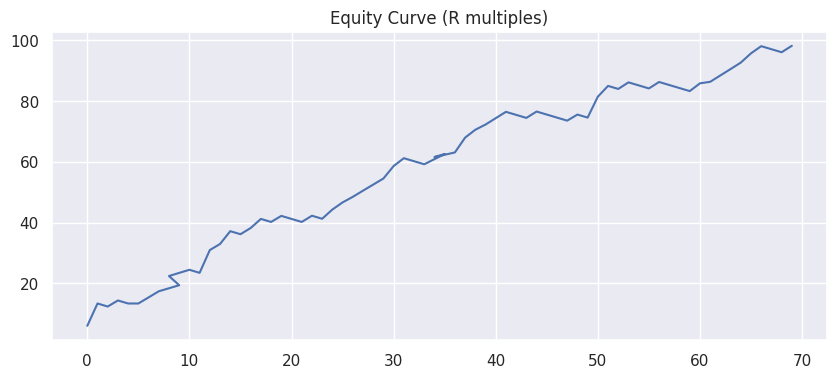

Max Drawdown (R): -3.0


In [17]:
print("Trades:", len(df))
print("Win rate:", df["is_win"].mean())
print("Average R:", df["R"].mean())
print("Median R:", df["R"].median())
print("Total R:", df["R"].sum())

# Equity curve
df = df.sort_values(DATE_COL)
df["equity_R"] = df["R"].cumsum()

plt.figure(figsize=(10,4))
plt.plot(df["equity_R"])
plt.title("Equity Curve (R multiples)")
plt.grid(True)
plt.show()

# Max drawdown
curve = df["equity_R"]
drawdown = curve - curve.cummax()
print("Max Drawdown (R):", drawdown.min())


DISTRIBUTION AND VISUAL EDA

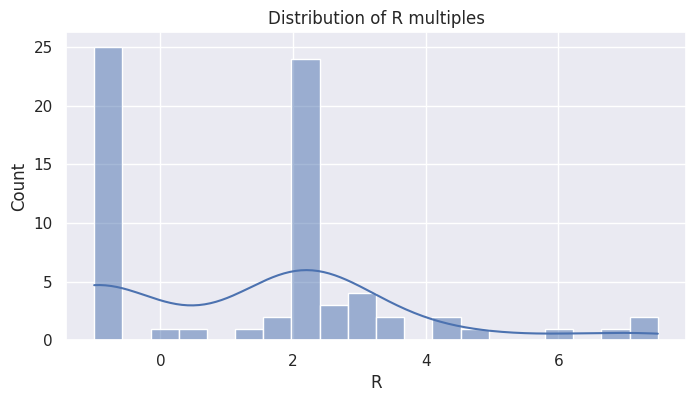

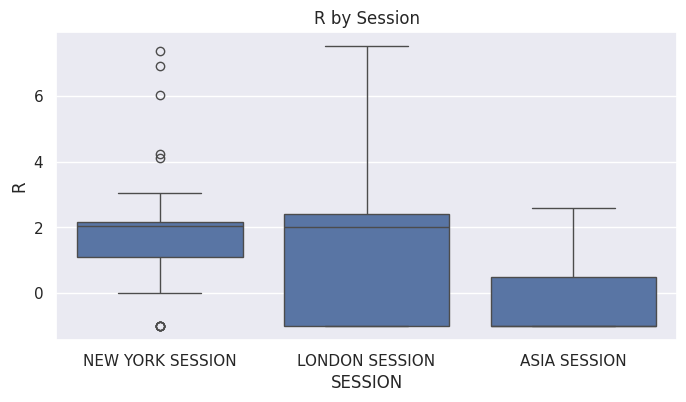

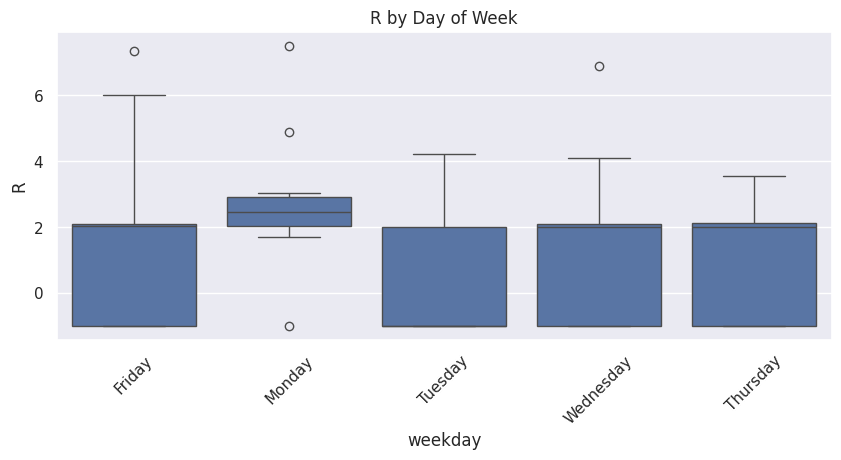

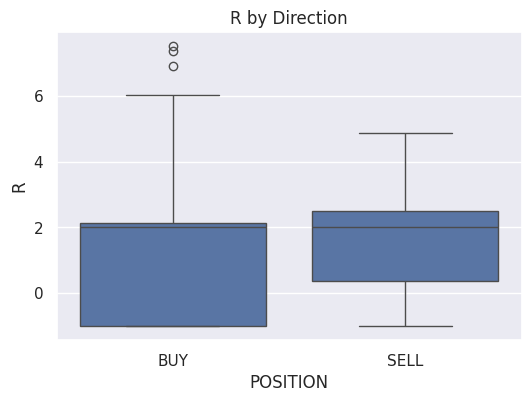

In [18]:
# R distribution
plt.figure(figsize=(8,4))
sns.histplot(df["R"], kde=True, bins=20)
plt.title("Distribution of R multiples")
plt.show()

# Boxplots
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="SESSION", y="R")
plt.title("R by Session")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="weekday", y="R")
plt.title("R by Day of Week")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="POSITION", y="R")
plt.title("R by Direction")
plt.show()


GROUPED PERFORMANCE TABLE

In [21]:
def performance_table(col):
    return (df.groupby(col)
              .agg(
                  trades=(col, "size"),
                  win_rate=("is_win", "mean"),
                  avg_R=("R", "mean"),
                  total_R=("R", "sum")
              )
            .sort_values("avg_R", ascending=False))

print("By SESSION:")
display(performance_table("SESSION"))

print("By WEEKDAY:")
display(performance_table("weekday"))

print("By POSITION:")
display(performance_table("POSITION"))


By SESSION:


,trades,win_rate,avg_R,total_R
SESSION,,,,
NEW YORK SESSION,31,0.774194,1.985806,61.56
LONDON SESSION,32,0.562500,1.159375,37.10
ASIA SESSION,7,0.285714,-0.058571,-0.41


By WEEKDAY:


,trades,win_rate,avg_R,total_R
weekday,,,,
Monday,14,0.928571,2.696429,37.75
Wednesday,14,0.642857,1.530000,21.42
Friday,15,0.600000,1.484000,22.26
Thursday,12,0.583333,0.989167,11.87
Tuesday,15,0.400000,0.330000,4.95


By POSITION:


,trades,win_rate,avg_R,total_R
POSITION,,,,
SELL,30,0.733333,1.603,48.09
BUY,40,0.550000,1.254,50.16


HYPOTHESIS TESTING
1. Does session affect win rate? (Chi-square Test)

In [34]:
#cont = pd.crosstab(df["SESSION"], df["is_win"])
#chi2, p, *_ = chi2_contingency(cont)
#print("p-value:", p)

contingency = pd.crosstab(df['SESSION'], df['is_win'])
chi2, p, dof, exp = chi2_contingency(contingency)

print("Chi-square value:", chi2)
print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Session has a significant effect on win rate.")
else:
    print("Fail to reject H0 → No significant difference between sessions.")


Chi-square value: 6.93851511391834
p-value: 0.031140141862240088
Reject H0 → Session has a significant effect on win rate.


2. Are sells more profitables than buys? (T-test)

In [37]:
#buys = df[df["POSITION"]=="BUY"]["R"]
#sells = df[df["POSITION"]=="SELL"]["R"]

#t, p = ttest_ind(buys, sells, equal_var=False)
#print("p-value:", p)

buys = df[df["POSITION"] == "BUY"]["R"]
sells = df[df["POSITION"] == "SELL"]["R"]

t, p = ttest_ind(buys, sells, equal_var=False)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Buys and sells have significantly different profitability.")
else:
    print("Fail to reject H0 → No significant difference.")

p-value: 0.49122392849665164
Fail to reject H0 → No significant difference.


3. Is Monday statistically better? (Z-test)

In [38]:
#mon = df[df["weekday"]=="Monday"]
#others = df[df["weekday"]!="Monday"]

#success = [mon["is_win"].sum(), others["is_win"].sum()]
#nobs = [len(mon), len(others)]

#stat, p = proportions_ztest(success, nobs, alternative="larger")
#print("p-value:", p)

monday = df[df['weekday'] == "Monday"]
others = df[df['weekday'] != "Monday"]

success = [monday['is_win'].sum(), others['is_win'].sum()]
nobs = [len(monday), len(others)]

stat, p = proportions_ztest(success, nobs, alternative='larger')
print("p-value:", p)

if p < 0.05:
    print("Reject H0 → Mondays outperform significantly.")
else:
    print("Fail to reject H0 → Monday edge may be noise.")


p-value: 0.004697729962432614
Reject H0 → Mondays outperform significantly.


4. Does R correlate with win probability

In [39]:
#r, p = pearsonr(df["R"], df["is_win"])
#print("Correlation:", r, "p-value:", p)

r, p = pearsonr(df['R'], df['is_win'])
print("Correlation:", r, "p-value:", p)

if p < 0.05:
    print("Reject H0 → R multiple is significantly associated with win rate.")
else:
    print("No significant correlation between R and win probability.")

Correlation: 0.8333440553212007 p-value: 3.57090254214475e-19
Reject H0 → R multiple is significantly associated with win rate.


5. Do winners and losers have different durations? (T-test)

In [30]:
def duration_to_hours(x):
    if pd.isna(x):
        return np.nan

    # Handle pandas time/datetime.time object
    try:
        return x.hour + x.minute/60 + x.second/3600
    except:
        pass

    # Handle string "HH:MM:SS"
    try:
        parts = str(x).split(":")
        if len(parts) == 3:
            h, m, s = parts
            return int(h) + int(m)/60 + int(s)/3600
        elif len(parts) == 2:
            h, m = parts
            return int(h) + int(m)/60
    except:
        return np.nan

    return np.nan


In [31]:
df["duration_hours"] = df["DURATION"].apply(duration_to_hours)


In [32]:
df["duration_hours"].head(20)


,duration_hours
0,21.750000
1,21.250000
2,5.500000
3,8.750000
4,5.250000
5,10.000000
6,5.083333
7,4.500000
9,1.000000
8,2.000000


In [41]:
#wins = df[df["is_win"]==1]["duration_hours"].dropna()
#losses = df[df["is_win"]==0]["duration_hours"].dropna()

#t, p = ttest_ind(wins, losses, equal_var=False)
#print("p-value:", p)
wins = df[df['is_win']==1]['duration_hours'].dropna()
losses = df[df['is_win']==0]['duration_hours'].dropna()

t, p = ttest_ind(wins, losses, equal_var=False)

print("p-value:", p)
if p < 0.05:
    print("Reject H0 → Duration affects win likelihood.")
else:
    print("Duration does not significantly influence win/loss.")

p-value: 0.4986348226279219
Duration does not significantly influence win/loss.
